# A Variational Autoencoder for generating pictures of cats

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,\
                         Conv2DTranspose, Flatten, Reshape, Lambda, ELU, BatchNormalization
from keras.models import Model
from keras.losses import binary_crossentropy, mse
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import keras.backend as kb
from src.vaeHelpers import *

%matplotlib inline

Using TensorFlow backend.


## Load the data

Load the data, create a training/validation split. Save the split to a file to help with continuation of training.

In [2]:
trainFresh = True

if ( trainFresh ):
    catFiles = np.array( glob('./cats/*.jpg') )
    
    valFrac = 0.1
    n = len(catFiles)
    
    inds = np.random.permutation( len(catFiles) )
    trainInds, valInds = inds[ : -int(n*valFrac) ], inds[ -int(n*valFrac) : ]
    
    train, val = catFiles[ trainInds ], catFiles[ valInds ]
    
    writeFilesList( "trainFiles.txt", train )
    writeFilesList( "valFiles.txt", val )

else:
    val   = readSavedFiles( "valFiles.txt" )
    train = readSavedFiles( "trainFiles.txt" )

## Set some parameters

In [3]:
batchSize = 32
codeSize  = 128
imgSize   = 200
filters   = 32

factor = imgSize * imgSize

## Define the model

In [4]:
inputs = Input( shape = ( imgSize, imgSize, 3,) )

conv1 = Conv2D( filters, 3, strides = 1, padding = 'same', data_format = "channels_last")( inputs )
bn1   = ELU()(BatchNormalization()(conv1))
pool1 = MaxPooling2D( data_format = "channels_last" )( bn1 )

conv2 = Conv2D( filters, 3, strides = 1, padding = 'same', data_format = "channels_last" )( pool1 )
bn2   = ELU()(BatchNormalization()(conv2))
pool2 = MaxPooling2D( data_format = "channels_last" )( bn2 )

conv3 = Conv2D( filters, 3, strides = 1, padding = 'valid', data_format = "channels_last" )( pool2 )
bn3   = ELU()(BatchNormalization()(conv3))
pool3 = MaxPooling2D( data_format = "channels_last" )( bn3 )

conv4 = Conv2D( filters, 3, strides = 1, padding = 'same', data_format = "channels_last" )( pool3 )
bn4   = ELU()(BatchNormalization()(conv4))
pool4 = MaxPooling2D( data_format = "channels_last" )( bn4 )

conv5 = Conv2D( filters, 3, strides = 1, padding = 'same', data_format = "channels_last" )( pool4 )
bn5   = ELU()(BatchNormalization()(conv5))
pool5 = MaxPooling2D( data_format = "channels_last" )( bn5 )

flat  = Flatten()( pool5 )

mean     = Dense( codeSize )( flat )
logSigma = Dense( codeSize )( flat )

encoding = Lambda(sampling, output_shape = ( codeSize,) )( [mean, logSigma] )

decoderInput = Input( shape = (codeSize, ) )

dense = Dense( filters * 6 * 6 )( decoderInput )
bn6   = ELU()(BatchNormalization()(dense))

unflatten = Reshape( (6, 6, filters) )(bn6 )

unpool1 = UpSampling2D( data_format = "channels_last" )( unflatten )
deconv1 = Conv2DTranspose( filters, 3, strides = 1, padding = 'same', data_format = "channels_last" )( unpool1 )
bn7     = ELU()(BatchNormalization()( deconv1 ))

unpool2 = UpSampling2D( data_format = "channels_last" )( bn7 )
deconv2 = Conv2DTranspose( filters, 3, strides = 1, padding = 'same', data_format = "channels_last" )( unpool2 )
bn8     = ELU()(BatchNormalization()( deconv2 ))

unpool3 = UpSampling2D( data_format = "channels_last" )( bn8 )
deconv3 = Conv2DTranspose( filters, 3, strides = 1, padding = 'valid', data_format = "channels_last" )( unpool3 )
bn9     = ELU()(BatchNormalization()( deconv3 ))

unpool4 = UpSampling2D( data_format = "channels_last" )( bn9 )
deconv4 = Conv2DTranspose( filters, 3, strides = 1, padding = 'same', data_format = "channels_last" )( unpool4 )
bn10    = ELU()(BatchNormalization()( deconv4 ))

unpool5  = UpSampling2D( data_format = "channels_last" )( bn10 )
decoding = Conv2DTranspose( 3, 3, strides = 1, padding = 'same', data_format = "channels_last", activation = "sigmoid" )( unpool5 )

In [5]:
encoder = Model( inputs, [mean, logSigma, encoding], name = 'encoder')
decoder = Model( decoderInput, decoding, name = "decoder")

fullPass = decoder( encoder(inputs)[2] )

VAE = Model( inputs, fullPass, name = 'vae' )

In [6]:
#reconLoss = factor * binary_crossentropy( kb.flatten( inputs ), kb.flatten( fullPass ) )
reconLoss = factor * mse( kb.flatten( inputs ), kb.flatten( fullPass ) )
klLoss = -0.5 * kb.sum(1 + logSigma - kb.square(mean) - kb.exp(logSigma), axis = -1 )
loss = kb.mean( reconLoss + klLoss )

opt = Adam() #Adam( lr = 0.0005, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.01 )

VAE.add_loss( loss )
VAE.compile( optimizer = opt, loss = None )

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  if __name__ == '__main__':


## Train the model

In [7]:
if ( not trainFresh ):
    VAE.load_weights( "weights/catGen.hdf5" )

earlyStoper  = EarlyStopping( patience = 30, verbose = 5 )
checkPointer = ModelCheckpoint( filepath = "weights/catGen.hdf5", verbose = 1, save_best_only = True )

losses = VAE.fit_generator( genBatch( train, batchSize, imgSize, True ),
                   validation_data = genBatch( val, batchSize, imgSize, False ),
                   epochs = 10,
                   validation_steps = len(val)//batchSize,
                   steps_per_epoch  = len(train)//batchSize,
                   callbacks = [ earlyStoper, checkPointer ] )

Epoch 1/10
280/281 [============================>.] - ETA: 0s - loss: 2045.6600
Epoch 00001: val_loss improved from inf to 1335.88203, saving model to weights/catGen.hdf5
281/281 [==============================] - 62s 222ms/step - loss: 2042.8506 - val_loss: 1335.8820
Epoch 2/10
280/281 [============================>.] - ETA: 0s - loss: 1713.6928
Epoch 00002: val_loss did not improve
281/281 [==============================] - 59s 211ms/step - loss: 1711.8839 - val_loss: 1385.9909
Epoch 3/10
280/281 [============================>.] - ETA: 0s - loss: 1661.9577
Epoch 00003: val_loss did not improve
281/281 [==============================] - 60s 213ms/step - loss: 1660.5976 - val_loss: 1516.9485
Epoch 4/10
280/281 [============================>.] - ETA: 0s - loss: 1713.2217
Epoch 00004: val_loss improved from 1335.88203 to 1160.81837, saving model to weights/catGen.hdf5
281/281 [==============================] - 60s 214ms/step - loss: 1711.3789 - val_loss: 1160.8184
Epoch 5/10
280/281 [===

## Plot a learning curve

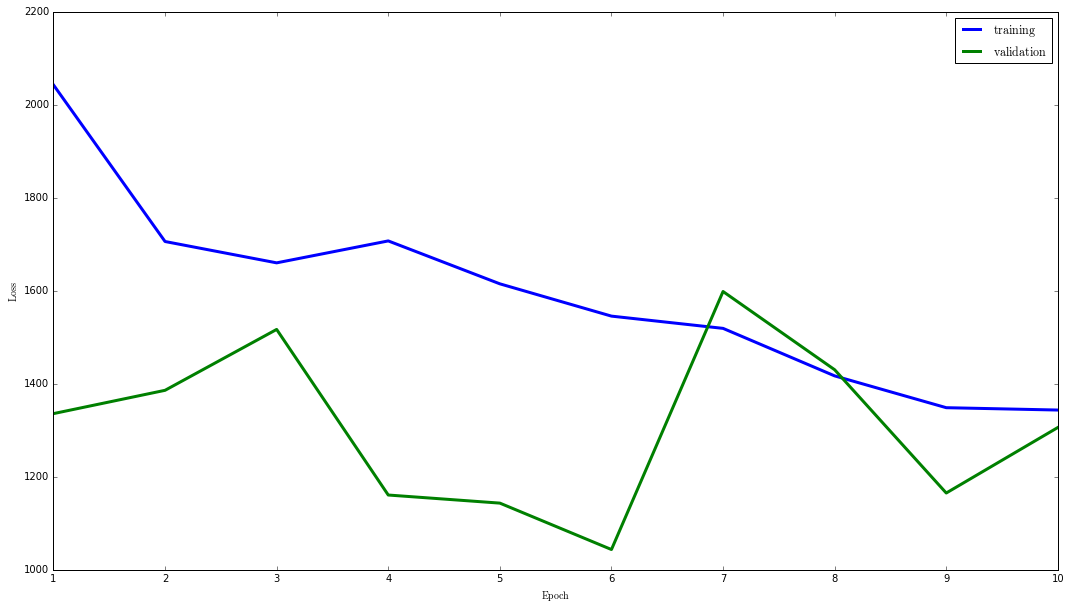

In [8]:
plotLosses( losses.history )

## Test the last training iteration

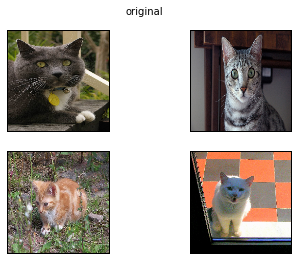

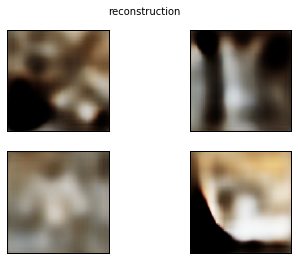

In [9]:
catSample, _ = next( genBatch( val, 4, imgSize = imgSize ) )
recon   = VAE.predict( catSample )

plotGrid( catSample, "original" )
plotGrid( recon, "reconstruction" )

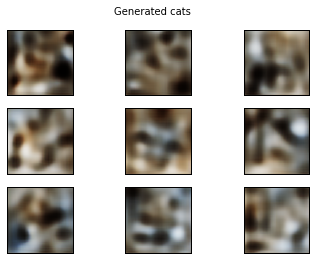

In [10]:
codes = np.random.normal( size = (9, codeSize) )
cats  = decoder.predict( codes )

plotGrid( cats, "Generated cats" )

## Best validation loss

In [11]:
VAE.load_weights( "weights/catGen.hdf5" )

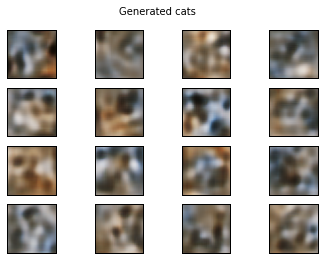

In [12]:
codes = np.random.normal( size = (16, codeSize) )
cats = decoder.predict( codes )

plotGrid( cats, "Generated cats" )

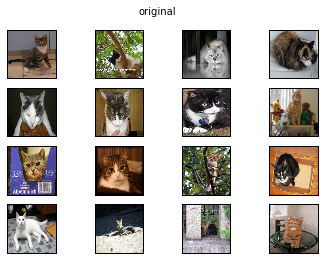

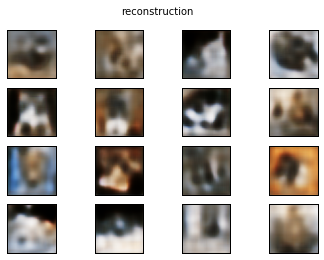

In [13]:
catSample, _ = next( genBatch( val, 16, imgSize, False ) )

recon = VAE.predict( catSample )

plotGrid( catSample, "original" )
plotGrid( recon, "reconstruction" )